# CX Circuits

Changing working directory from `./notebooks/` to `./`, in order to import the Python packages defined in the repository.

In [1]:
import os
DEBUG = True
try:
    print("Original working directory: %s"%str(original_wd)) # type: ignore
    """
        You only get here if you---by mistake or otherwise---are re-running this cell, 
        in which case the working should not be changed again.
    """
except NameError:
    original_wd = os.getcwd()
    os.chdir('../')
print("Current working directory: %s"%str(os.getcwd()))

Current working directory: C:\Users\Stefa\Documents\git\pauliopt


General purpose imports:

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
# import qiskit

Some utility code to display HTML elements and images/figures side-by-side:

In [3]:
from io import BytesIO
from typing import Union
from IPython.display import Image, HTML # type: ignore
def figure_to_image(fig: plt.Figure, fmt: str = "png") -> Image:
    """ Converts a Matplotlib figure to a PNG IPython Image. """
    buffer = BytesIO()
    fig.savefig(buffer, format=fmt)
    buffer.seek(0)
    image_png = buffer.getvalue()
    buffer.close()
    return Image(image_png, format=fmt, embed=True)
def side_by_side(*elements: Union[str, Image]) -> HTML:
    """
        Returns an HTML Div element with the given elements
        displayed side by side. Accepts raw HTML code or
        IPython Image objects.
    """
    html = f"<div style='display:flex; align-items: center;'>"
    for el in elements:
        if isinstance(el, str):
            html += el
        elif isinstance(el, Image):
            html += f"<img src='data:image/png;base64,{el._repr_png_()}'/>"
    html += f"</div>"
    return HTML(html)

## Conjugation by CX Circuits

One of the optimisation techniques for a circuit $\mathcal{C}$ of mixed ZX phase gadgets proceeds through conjugation of the circuit by a suitably chosen block $U$ of CX gates, obtaining another circuit $U \circ \mathcal{C}' \circ U^\dagger$ (hopefully simpler overall).

These CX circuits are constructed and manipulated using the classes `CXCircuit` and `CXCircuitLayer`. Read-only views of such circuits are made available by the respective `as_readonly` properties, through the `CXCircuitView` and `CXCircuitLayerView` classes.

In [4]:
from pauliopt.phase import CXCircuit, CXCircuitLayer

## CX Circuit Layers

A single layer of a CX circuit is constructed with `CXCircuitLayer` from a topology and a collection of CX gates, specified as pairs `(ctrl, trgt)` of control and target qubits (in `CXCircuitLayer.topology.qubits`).
It uses a `Matching` instance internally to keep track of which qubit pairs are covered by some gate.

In [5]:
from pauliopt.topologies import Topology
topology = Topology.grid(3,3)
layer = CXCircuitLayer(topology, [[0, 1], [2, 5], [6, 7]])

CX circuit layers exposes the underlying topology, number of gates and gates through suitably named read-only properties. Note that the `CXCircuitLayer.gates` property involves the creation of a fresh frozen-set at every call, since gates are stored internally in a different data structure.   

In [6]:
print(f"{layer.topology = }")
print(f"{layer.num_gates = }")
print(f"{layer.gates = }")

layer.topology = Topology({0, 1, 2, 3, 4, 5, 6, 7, 8}, [{3, 4}, {1, 4}, {1, 2}, {0, 3}, {4, 5}, {0, 1}, {3, 6}, {6, 7}, {2, 5}, {7, 8}, {5, 8}, {4, 7}])
layer.num_gates = 3
layer.gates = frozenset({(0, 1), (6, 7), (2, 5)})


CX circuit layers expose information about the gate incident to any given qubit (if any), through the `CXCircuitLayer.incident(qubit)` method.

In [7]:
for q in layer.topology.qubits:
    print(f"Gate on qubit {q}: {layer.incident(q)}")

Gate on qubit 0: (0, 1)
Gate on qubit 1: (0, 1)
Gate on qubit 2: (2, 5)
Gate on qubit 3: None
Gate on qubit 4: None
Gate on qubit 5: (2, 5)
Gate on qubit 6: (6, 7)
Gate on qubit 7: (6, 7)
Gate on qubit 8: None


CX circuit layers can be drawn using the `CXCircuitLayer.draw(**kwargs)` method. The allowed keyword arguments are those of `Topology.draw(**kwargs)`, plus `zcolor` and `xcolor` to control the colours for the Z and X dots in CX gates (analogous to `PhaseCircuit.to_svg(**kwargs)`).  

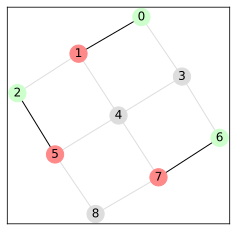

In [8]:
layer.draw(figsize=(4,4))

## CX Gate Flipping

CX circuit layers are modified by "flipping" CX gates, which can mean either:

- removing a CX gate currently in the layer;
- adding a CX gate to the layer on a pair of qubits, as long as neither qubit has an incident CX gate already.

This guarantees that all CX gates in a layer can be performed simultaneously on the given qubit topology.

The list of CX gates that can be flipped in a layer is exposed by the `CXCircuitLayer.flippable_cxs` property.

Flippable CX gates: frozenset({(0, 1), (3, 4), (4, 3), (6, 7), (2, 5)})


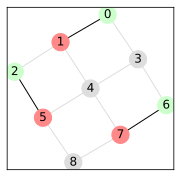

In [9]:
print(f"Flippable CX gates: {layer.flippable_cxs}")
layer.draw(figsize=(3,3))

The `CXCircuitLayer.is_cx_flippable(ctrl, trgt)` boolean property can be used to check whether the CX gate with given control and target is flippable.

layer.is_cx_flippable(4, 3) = True
layer.is_cx_flippable(2, 5) = True
layer.is_cx_flippable(1, 0) = False
layer.is_cx_flippable(7, 4) = False
layer.is_cx_flippable(1, 2) = False


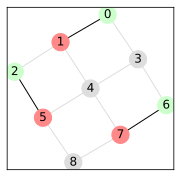

In [10]:
print(f"{layer.is_cx_flippable(4, 3) = }") # no incident gates on qubits
print(f"{layer.is_cx_flippable(2, 5) = }") # gate in circuit
print(f"{layer.is_cx_flippable(1, 0) = }") # incident gate on both qubits
print(f"{layer.is_cx_flippable(7, 4) = }") # incident gate on one qubit
print(f"{layer.is_cx_flippable(1, 2) = }") # incident gates on both qubits
layer.draw(figsize=(3,3))

A CX gate with given control and target can be flipped using the `CXCircuitLayer.flip_cx(ctrl, trgt)` method (not available on the read-only view `CXCircuitLayerView`). The following example shows a CX gate being introduced on a pair of qubits `{3, 4}` neither of which already has a CX gate incident on it.

Before flipping (4,3):


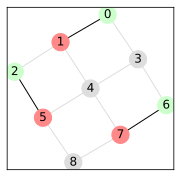

After flipping (4,3):


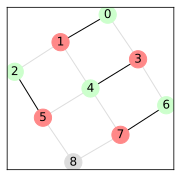

In [11]:
print("Before flipping (4,3):")
layer.draw(figsize=(3,3))
layer.flip_cx(4,3)
print("After flipping (4,3):")
layer.draw(figsize=(3,3))

The following example shows a CX gate being removed from a circuit:

Before flipping (6,7):


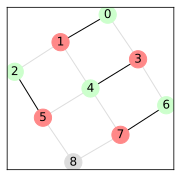

After flipping (6,7):


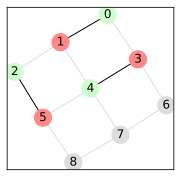

In [12]:
print("Before flipping (6,7):")
layer.draw(figsize=(3,3))
layer.flip_cx(6,7)
print("After flipping (6,7):")
layer.draw(figsize=(3,3))

The in-place right-shift operator `>>=` can also be used to flip CX gates in a layer, resulting in a more compact syntax.

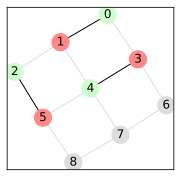

In [13]:
layer = CXCircuitLayer(topology, [[0, 1], [2, 5], [6, 7]])
layer >>= [4, 3], [6,7]
layer.draw(figsize=(3,3))

In fact, CX circuit layers can be created entirely with the in-place right-shift operator.

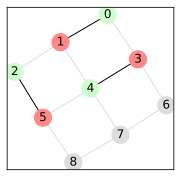

In [14]:
layer = CXCircuitLayer(topology)
layer >>= [0, 1], [2, 5], [6, 7], [4, 3], [6,7]
layer.draw(figsize=(3,3))

## CX Circuits

CX Circuits are constructed with `CXCircuit` from a topology and a sequence of CX circuit layers.

In [15]:
circuit = CXCircuit(topology, [
    CXCircuitLayer(topology, [[0, 1], [2, 5], [6, 7]]),
    CXCircuitLayer(topology, [[1, 2], [5, 4], [8, 7], [3, 6]]),
    CXCircuitLayer(topology, [[0, 1], [4, 3], [7, 6]]),
])

CX circuits are a sequence of CX circuit layers: they can be iterated, individual layers can be accessed and the number of layers can be obtained with `len()`.

Number of layers in circuit: 3
Gates in layer 0: frozenset({(0, 1), (6, 7), (2, 5)})
Gates in layer 1: frozenset({(8, 7), (5, 4), (1, 2), (3, 6)})
Gates in layer 2: frozenset({(0, 1), (7, 6), (4, 3)})

Layer 0:


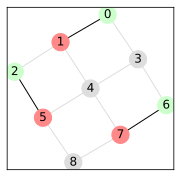

In [16]:
print(f"Number of layers in circuit: {len(circuit)}")
for layer_idx, layer in enumerate(circuit):
    print(f"Gates in layer {layer_idx}: {layer.gates}")
print()
print("Layer 0:")
circuit[0].draw(figsize=(3, 3))

## Drawing CX Circuits

The `CXCircuit.draw` draws a CX circuit by drawing its individual layers left-to-right. The optional `figsize` parameter refers to the size of the individual layer sub-figures.

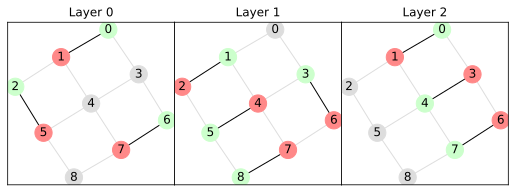

In [17]:
circuit.draw(figsize=(3,3))

The in-place right-shift operator `>>=` can also be used to append layers to a CX circuit, resulting in a more compact syntax.

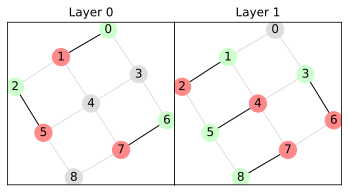

In [18]:
circuit = CXCircuit(topology)
circuit >>= CXCircuitLayer(topology, [[0, 1], [2, 5], [6, 7]])
circuit >>= CXCircuitLayer(topology, [[1, 2], [5, 4], [8, 7], [3, 6]])
circuit.draw(figsize=(3,3))

In fact, the sequences of gates in each layer can be passed directly to the operator, further improving legibility.

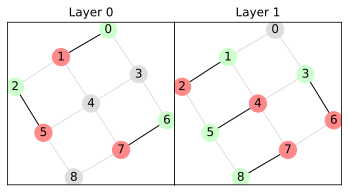

In [19]:
circuit = CXCircuit(topology)
circuit >>= [[0, 1], [2, 5], [6, 7]]
circuit >>= [[1, 2], [5, 4], [8, 7], [3, 6]]
circuit.draw(figsize=(3,3))

Passing multiple layers to the operator on a line is allowed, but discouraged. If you do, make sure you understand that each layer should be passed as a list of gates (otherwise the gates will all be merged into a single layer, usually raising an error because some flips are invalid).

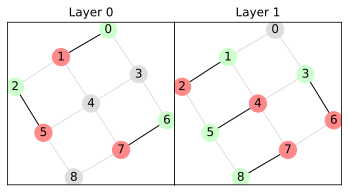

In [20]:
circuit = CXCircuit(topology)
circuit >>= [[0, 1], [2, 5], [6, 7]], [[1, 2], [5, 4], [8, 7], [3, 6]]
circuit.draw(figsize=(3,3))

Example of an error when passing multiple layers all in one go:

In [21]:
circuit = CXCircuit(topology)
try:
    circuit >>= [0, 1], [2, 5], [6, 7], [1, 2], [5, 4], [8, 7], [3, 6]
except Exception as e:
    print("Error:", e)

Error: Cannot add CX gate (1, 2) to the layer: gate is not present, but one of control or target is already involved in some other gate.
